In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI: Track artifacts and metrics across Vertex AI Pipelines runs using Vertex ML Metadata

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/ml_metadata/vertex-pipelines-ml-metadata.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/ml_metadata/vertex-pipelines-ml-metadata.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/ml_metadata/vertex-pipelines-ml-metadata.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
     </a>
     </td>
</table>

## Overview

This notebook demonstrates how to track metrics and artifacts across Vertex AI Pipelines runs, and analyze this metadata using the Vertex AI SDK for Pyrhon. If you'd prefer to follow a step-by-step tutorial, check out the [codelab version](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0) of this notebook.

Learn more about [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata) and [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction).

### Objective

In this notebook, you learn how to track artifacts and metrics with Vertex ML Metadata in Vertex AI Pipeline runs.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Pipelines
- Vertex ML Metadata

The steps performed include:

* Use the Kubeflow Pipelines SDK to build an ML pipeline that runs on Vertex AI.
* The pipeline creates a dataset, trains a scikit-learn model, and deploys the model to an endpoint.
* Write custom pipeline components that generate artifacts and metadata.
* Compare Vertex AI Pipelines runs, both in the Google Cloud console and programmatically.
* Trace the lineage for pipeline-generated artifacts.
* Query your pipeline run metadata.

### Dataset

In this notebook, you'll train a model using scikit-learn to classify bean types using the [Dry Beans Dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset) from UCI Machine Learning. This is a tabular dataset that includes measurements and characteristics of seven different types of beans taken from images.

### Costs


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Install additional packages

Run the following commands to install the Vertex AI SDK for Python and packages used in this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 'kfp<2.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.9/304.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00


### Colab only: Uncomment the following cell to restart the kernel

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "crypto-isotope-366706"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
from google.colab import auth
auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

#### Enable Cloud services used throughout this notebook.

Run the cell below to the enable Compute Engine, Container Registry, and Vertex AI services.

In [ ]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com

Operation "operations/acat.p2-848384636885-3a993d04-44a5-43e0-9cb4-d4b5fe9860b4" finished successfully.


### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://your-bucket-name-crypto-isotope-366706-unique/...


### Service Account

Use a service account to create Vertex AI Pipeline jobs.

If you don't want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 848384636885-compute@developer.gserviceaccount.com


#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Import libraries and define constants

Import required libraries.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# We'll use this beta library for metadata querying
from google.cloud import aiplatform, aiplatform_v1beta1
from google.cloud.aiplatform import pipeline_jobs
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import (Artifact, Dataset, Input, Metrics, Model, Output,
                        OutputPath, component)

Define some constants

In [ ]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin
REGION = "us-central1"

PIPELINE_ROOT = f"{BUCKET_URI}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/home/jupyter/.local/bin


'gs://your-bucket-name-crypto-isotope-366706-unique/pipeline_root/'

Initialize the Vertex AI SDK

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION)

## Concepts

To better understand [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) and [Vertex AI ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata), here’re some relevant concepts:


### Pipeline Run
The term “run” refers to a single execution of your pipeline in Vertex AI Pipelines. Each run generates artifacts, metrics, and associated metadata.

### Artifact

An artifact is a resource generated by your pipeline. Artifacts could datasets, models, endpoints, or custom resources defined in your pipeline.

### Metric

A metric is a way to measure the performance of your pipeline runs and artifacts. For example, a metric could be the accuracy of a classification model artifact created in your pipeline, or the size of the dataset used to train your model.

### Metadata

Metadata describes the artifacts and metrics generated by your pipeline runs. Metadata on a model, for example, could include the URL of the model artifacts, its name, and the time it was created.

## Creating a 3-step pipeline with custom components

The focus of this lab is on understanding metadata from pipeline runs. In order to do that, you'll need a pipeline to run on Vertex AI Pipelines, which is where you’ll start. Here you’ll define a 3-step pipeline with the following custom components:

* `get_dataframe`: Retrieve data from a BigQuery table and convert it into a pandas DataFrame.
* `train_sklearn_model`: Use the pandas DataFrame to train and export a scikit-learn model, along with some metrics.
* `deploy_model`: Deploy the exported scikit-learn model to an endpoint in Vertex AI.

### Create and define Python function based components

First, define the `get_dataframe` component with the code below. This component does the following:
* Creates a reference to a BigQuery table using the BigQuery client library
* Downloads the BigQuery table and converts it to a shuffled pandas DataFrame
* Exports the DataFrame to a CSV file

In [ ]:
@component(
    packages_to_install=["google-cloud-bigquery", "pandas", "pyarrow", "db-dtypes"],
    base_image="python:3.9",
    output_component_file="create_dataset.yaml",
)
def get_dataframe(bq_table: str, output_data_path: OutputPath("Dataset")):
    from google.cloud import bigquery

    bqclient = bigquery.Client(project="crypto-isotope-366706")
    table = bigquery.TableReference.from_string(bq_table)
    rows = bqclient.list_rows(table)
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2)
    dataframe.to_csv(output_data_path)

Next, create a component to train a scikit-learn model. This component does the following:
* Imports a CSV as a pandas DataFrame.
* Splits the DataFrame into train and test sets.
* Trains a scikit-learn model.
* Logs metrics from the model.
* Saves the model artifacts as a local `model.joblib` file.

In [ ]:
@component(
    packages_to_install=["scikit-learn", "pandas", "joblib"],
    base_image="python:3.9",
    output_component_file="beans_model_component.yaml",
)
def sklearn_train(
    dataset: Input[Dataset], metrics: Output[Metrics], model: Output[Model]
):
    import pandas as pd
    from joblib import dump
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier

    df = pd.read_csv(dataset.path)
    labels = df.pop("Class").tolist()
    data = df.values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, labels)

    skmodel = DecisionTreeClassifier()
    skmodel.fit(x_train, y_train)
    score = skmodel.score(x_test, y_test)
    print("accuracy is:", score)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "Scikit Learn")
    metrics.log_metric("dataset_size", len(df))
    dump(skmodel, model.path + ".joblib")

Finally, the last component  takes the trained model from the previous step, uploads the model to Vertex AI, and deploys it to an endpoint:

In [ ]:
@component(
    packages_to_install=["google-cloud-aiplatform"],
    base_image="python:3.9",
    output_component_file="beans_deploy_component.yaml",
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model],
):
    from google.cloud import aiplatform

    aiplatform.init(project=project, location=region)

    deployed_model = aiplatform.Model.upload(
        display_name="beans-model-pipeline",
        artifact_uri=model.uri.replace("model", ""),
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    # Save data to the output params
    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name

### Define and compile the pipeline

In [ ]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="mlmd-pipeline",
)
def pipeline(
    bq_table: str = "",
    output_data_path: str = "data.csv",
    project: str = PROJECT_ID,
    region: str = REGION,
):
    dataset_task = get_dataframe(bq_table)

    model_task = sklearn_train(dataset_task.output)

    deploy_model(model=model_task.outputs["model"], project=project, region=region)

The following generates a JSON file that you'll use to run the pipeline:

In [ ]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path="mlmd_pipeline.json")

### Start two pipeline runs

Next you'll kick ofg **two** runs of our pipeline. First, define a timestamp to use for our pipeline job IDs:

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

The pipeline takes one parameter when you run it: the `bq_table` we want to use for training data you’ll use for training data. This pipeline run uses a smaller version of the beans dataset:

In [ ]:
run1 = pipeline_jobs.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-small-{}".format(TIMESTAMP),
    parameter_values={"bq_table": "sara-vertex-demos.beans_demo.small_dataset"},
    enable_caching=True,
)

Next, create another pipeline run using a larger version of the same dataset.

In [ ]:
run2 = pipeline_jobs.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-large-{}".format(TIMESTAMP),
    parameter_values={"bq_table": "sara-vertex-demos.beans_demo.large_dataset"},
    enable_caching=True,
)

Finally, kick off pipeline executions for both runs. It's best to do this in two separate notebook cells so you can see the output for each run.

In [ ]:
run1.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20240324184419
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20240324184419')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-small-20240324184419?project=848384636885


Then, kick off the second run:

In [ ]:
run2.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20240324184419
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20240324184419')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-large-20240324184419?project=848384636885


After running this cell, you'll see a link to view each pipeline in the Google Cloud console. Open that link to see more details on your pipeline.

**These pipeline runs will take 10-15 minutes to complete.**

## Comparing pipeline runs

Now that you have two pipeline completed pipeline runs, you're ready to take a closer look at pipeline metrics using the Vertex AI SDK for Python.

**For guidance on inspecting pipeline artifacts and metadata in the Google Cloud console, see [this codelab](https://codelabs.developers.google.com/vertex-mlmd-pipelines#5).**

You can use the `aiplatform.get_pipeline_df()` method to access run metadata. Here, you'll get metadata for the last two runs of the same pipeline and load it into a Pandas DataFrame. The `mlmd-pipeline` parameter here refers to the name you gave your pipeline in the pipeline definition:

In [ ]:
df = aiplatform.get_pipeline_df(pipeline="mlmd-pipeline")
print(df)

   pipeline_name                            run_name  \
0  mlmd-pipeline  mlmd-pipeline-small-20240324184419   
1  mlmd-pipeline  mlmd-pipeline-large-20240324184419   
2  mlmd-pipeline  mlmd-pipeline-small-20240324184010   
3  mlmd-pipeline  mlmd-pipeline-large-20240324184010   
4  mlmd-pipeline  mlmd-pipeline-large-20240324183159   
5  mlmd-pipeline  mlmd-pipeline-small-20240324183159   
6  mlmd-pipeline  mlmd-pipeline-large-20240324180531   
7  mlmd-pipeline  mlmd-pipeline-small-20240324180531   

  param.vertex-ai-pipelines-artifact-argument-binding    param.input:project  \
0  {'output:sklearn-train-metrics': ['projects/84...   crypto-isotope-366706   
1  {'output:sklearn-train-metrics': ['projects/84...   crypto-isotope-366706   
2                                                NaN   crypto-isotope-366706   
3                                                NaN   crypto-isotope-366706   
4                                                NaN   crypto-isotope-366706   
5              

You’ve only executed the pipeline twice here, but you can imagine how many metrics you'd have with more executions. Next, create a custom visualization with matplotlib to see the relationship between the model's accuracy and the amount of data used for training. Run the following to generate a graph:

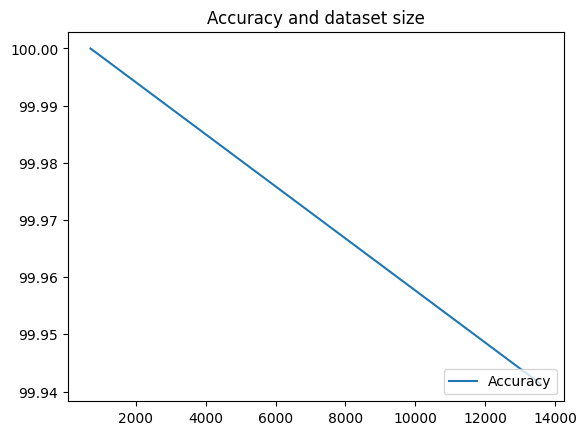

In [ ]:
plt.plot(df["metric.dataset_size"], df["metric.accuracy"], label="Accuracy")
plt.title("Accuracy and dataset size")
plt.legend(loc=4)
plt.show()

## Querying pipeline metrics

In addition to getting a DataFrame of all pipeline metrics, you may want to programmatically query artifacts created in your ML system. From there you can create a custom dashboard or let others in your organizaiton get details on specific artifacts.

### Getting all Model artifacts

To query artifacts in this way, you'll create a `MetadataServiceClient`:

In [ ]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
metadata_client = aiplatform_v1beta1.MetadataServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

Next, make a `list_artifacts` request to that endpoint and pass a filter indicating which artifacts you'd like in your response. First, let's get all the artifacts in the project that are **models**. To do that, run the following in your notebook:

In [ ]:
MODEL_FILTER = 'schema_title = "system.Model"'
artifact_request = aiplatform_v1beta1.ListArtifactsRequest(
    parent="projects/{}/locations/{}/metadataStores/default".format(PROJECT_ID, REGION),
    filter=MODEL_FILTER,
)
model_artifacts = metadata_client.list_artifacts(artifact_request)

The resulting `model_artifacts` response contains an iterable object for each model artifact in your project, along with associated metadata for each model.

### Filtering objects and displaying in a DataFrame

Next, get all artifacts created after August 10, 2021 with a `LIVE` state. After you run this request, display the results in a pandas DataFrame. First, execute the request:

In [ ]:
LIVE_FILTER = 'create_time > "2021-08-10T00:00:00-00:00" AND state = LIVE'
artifact_req = {
    "parent": "projects/{}/locations/{}/metadataStores/default".format(
        PROJECT_ID, REGION
    ),
    "filter": LIVE_FILTER,
}
live_artifacts = metadata_client.list_artifacts(artifact_req)

Then, display the results in a DataFrame:

In [ ]:
data = {"uri": [], "createTime": [], "type": []}

for i in live_artifacts:
    data["uri"].append(i.uri)
    data["createTime"].append(i.create_time)
    data["type"].append(i.schema_title)

df = pd.DataFrame.from_dict(data)
print(df)

                                                 uri  \
0  gs://your-bucket-name-crypto-isotope-366706-un...   
1  gs://your-bucket-name-crypto-isotope-366706-un...   
2  gs://your-bucket-name-crypto-isotope-366706-un...   
3  gs://your-bucket-name-crypto-isotope-366706-un...   
4  gs://your-bucket-name-crypto-isotope-366706-un...   
5  gs://your-bucket-name-crypto-isotope-366706-un...   
6  https://us-central1-aiplatform.googleapis.com/...   

                        createTime                  type  
0 2024-03-24 18:46:28.674000+00:00        system.Metrics  
1 2024-03-24 18:46:28.656000+00:00          system.Model  
2 2024-03-24 18:45:49.170000+00:00        system.Metrics  
3 2024-03-24 18:45:49.153000+00:00          system.Model  
4 2024-03-24 18:44:35.677000+00:00        system.Dataset  
5 2024-03-24 18:44:36.679000+00:00        system.Dataset  
6 2024-03-24 13:09:49.437000+00:00  google.VertexDataset  


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

If you don't want to delete the project, do the following to clean up the resources you used:

* If you used Vertex AI Workbench notebooks to run this, stop or delete the notebook instance.

* The pipeline runs you executed deployed endpoints in Vertex AI. Navigate to the [Google Cloud console](https://console.cloud.google.com/vertex-ai/endpoints) to delete those endpoints.

* Delete the [Cloud Storage bucket](https://console.cloud.google.com/storage/browser/) you created.

In [ ]:
import os

try:
    run1.delete()
    run2.delete()
except Exception as e:
    print(e)

delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}

INFO:google.cloud.aiplatform.base:Deleting PipelineJob : projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20240324184419
INFO:google.cloud.aiplatform.base:Delete PipelineJob  backing LRO: projects/848384636885/locations/us-central1/operations/4633681782900785152
INFO:google.cloud.aiplatform.base:PipelineJob deleted. . Resource name: projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20240324184419
INFO:google.cloud.aiplatform.base:Deleting PipelineJob : projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20240324184419
INFO:google.cloud.aiplatform.base:Delete PipelineJob  backing LRO: projects/848384636885/locations/us-central1/operations/5948732874092969984
INFO:google.cloud.aiplatform.base:PipelineJob deleted. . Resource name: projects/848384636885/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20240324184419
